In [1]:
import os 

import numpy as np

from astropy.cosmology import WMAP5 as cosmo
from astropy.table import Table
from astropy import units as u 
from astropy.coordinates import SkyCoord

import kcorrect
import kcorrect.utils as ut

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

# Load Astrodeep Catalogs

In [3]:
filter_list = [
    'F435W',
    'F606W',
    'F814W',
    'F105W',
    'F140W',
    'F160W',
    #'MAG_IRAC1',
    #'MAG_IRAC2'
]

hst_correction_const_dict = {
    'MAG_B435': 0.102,
    'MAG_V606': -0.088,
    'MAG_I814': -0.426,
    'MAG_Y105': -0.647,
    'MAG_J125': -0.903,
    'MAG_JH140': -1.078,
    'MAG_H160': -1.254,
    'MAG_IRAC1': -2.787,
    'MAG_IRAC2': -3.260
}

In [4]:
# raw_astro_deep_cat = Table.read("https://stsci.box.com/shared/static/2dsckrbt7b4eocl2v2mot9ssso0stc11.cat", format="ascii")
#raw_astro_deep_cat = Table.read("http://astrodeep.u-strasbg.fr/ff/data/catalogues/A2744CL.xml")
raw_astro_deep_cat = Table.read("http://data.muse-vlt.eu/A2744/A2744_redshifts_cat_final.csv")

print(len(raw_astro_deep_cat))

514


In [5]:
[i for i in raw_astro_deep_cat.colnames if "ERR" not in i and "F" in i]
raw_astro_deep_cat

# ID,RA,DEC,Z,CONFID,TYPE,MUL,F435W,F435W_ERR,F606W,F606W_ERR,F814W,F814W_ERR,F105W,F105W_ERR,F110W,F110W_ERR,F140W,F140W_ERR,F160W,F160W_ERR,MU,MU_ERR
str5,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
M39,3.5889097,-30.3821391,6.6439,2,6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,3.342,0.116
2115,3.5938048,-30.4154482,6.5876,2,6,--,-29.4385,99.0,-29.2385,99.0,29.4057,0.2892,-2.0,99.0,26.5916,0.0397,26.7413,0.0434,26.7002,0.0383,4.08,0.076
M38,3.5801476,-30.4079034,6.5565,2,6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,3.507,0.104
M37,3.5830603,-30.4118859,6.5195,2,6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,3.367,0.116
10609,3.598419,-30.3872993,6.3755,2,6,--,-30.3958,99.0,30.129,0.3502,29.6988,0.1612,29.8414,0.2013,29.6225,0.2425,-30.1464,99.0,30.0003,0.3039,2.279,0.069
5353,3.6010732,-30.4039891,6.3271,3,6,--,-29.5695,99.0,-29.4675,99.0,29.0818,0.1802,27.8385,0.0604,27.8021,0.0857,27.9608,0.0946,28.0404,0.0938,3.812,0.122
2785,3.5676318,-30.4118712,6.2737,2,6,--,-29.9169,99.0,29.5461,0.3228,28.8554,0.1205,28.6472,0.1217,28.7018,0.1896,28.7897,0.1977,28.5387,0.1413,1.68,0.028
M36,3.578052,-30.4131601,6.0938,2,6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,2.134,0.043
M35,3.5685679,-30.3990763,5.9971,2,6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,2.384,0.064


In [76]:
min_z = 0.1
max_z = 1

min_mag = -np.inf
max_mag = np.inf

astro_deep_mask = np.ones((len(raw_astro_deep_cat))).astype(bool)

#astro_deep_mask = astro_deep_mask & np.invert(raw_astro_deep_cat['ZBEST'].mask.astype(bool))
astro_deep_mask = astro_deep_mask & (raw_astro_deep_cat['Z'] > min_z).astype(bool).data  
astro_deep_mask = astro_deep_mask & (raw_astro_deep_cat['Z'] < max_z).astype(bool).data 
astro_deep_mask = astro_deep_mask & (raw_astro_deep_cat['Z'] != 0).astype(bool).data 

for f in filter_list:
    astro_deep_mask = astro_deep_mask & (raw_astro_deep_cat[f] > min_mag).astype(bool).data
    astro_deep_mask = astro_deep_mask & (raw_astro_deep_cat[f] < max_mag).astype(bool).data 


astro_deep_cat = raw_astro_deep_cat[astro_deep_mask]
print(len(astro_deep_cat))

228


In [77]:
cat = {}

mags = {}
mag_err = {}

maggies = {}
maggies_err = {}

z_best = np.array(astro_deep_cat['Z'])

num_sources = None

for f in filter_list:
    cat[f] = astro_deep_cat[f]
    
    mags[f] = np.array(astro_deep_cat[f][:]) 
    mag_err[f] = np.array(astro_deep_cat[f.replace('W', 'W_ERR')][:]) 
    
    maggies[f] = ut.mag2maggies(mags[f])
    maggies_err[f] = ut.invariance(maggies[f], mag_err[f])
    
    if num_sources is None:
        num_sources = len(cat[f])
    else:
        assert num_sources == len(cat[f])

        

/opt/conda/envs/lcbg/lib/python3.8/site-packages/kcorrect/utils/__init__.py:17: RuntimeWarning: divide by zero encountered in power
  return  numpy.power(0.4*numpy.log(10.)*maggies*mag_err, -2)


In [131]:
robel_cat = Table.read('hlsp_frontier_hst_abell2744_v1.0_drz_patrosian_catalog.csv')
robel_ra, robel_dec = np.array([ coord.split(',') for coord in robel_cat['sky_centroid']]).astype(float).transpose()

robel_coords = SkyCoord(
    ra=robel_cat['ra']*u.degree,
    dec=robel_cat['dec']*u.degree
)

astro_deep_coords = SkyCoord(
    ra=np.array(astro_deep_cat['RA'])*u.degree,
    dec=np.array(astro_deep_cat['DEC'])*u.degree
)


idx, sep2d, dist3d = astro_deep_coords.match_to_catalog_sky(robel_coords)

arcsec_cutoff = 1

radii = []
for item in robel_cat['r_half_light_arcsec_f160w'][idx]:
    if item == "None":
        item = np.nan 
    radii.append(item)
    
radii = np.array(radii, dtype=np.float)
radii[np.where(sep2d.arcsec > arcsec_cutoff)] = np.nan

print("Num sources with radii matchs: ", np.where(sep2d.arcsec < arcsec_cutoff)[0].shape[0])
print("Fraction sources with radii matchs: ", 1 - np.where(sep2d.arcsec > arcsec_cutoff)[0].shape[0] / len(astro_deep_cat))
print("Number of nan values", np.where(np.isnan(radii))[0].shape[0])

Num sources with radii matchs:  188
Fraction sources with radii matchs:  0.8245614035087719
Number of nan values 48


In [132]:
228-188

40

single bin width= 0.009932


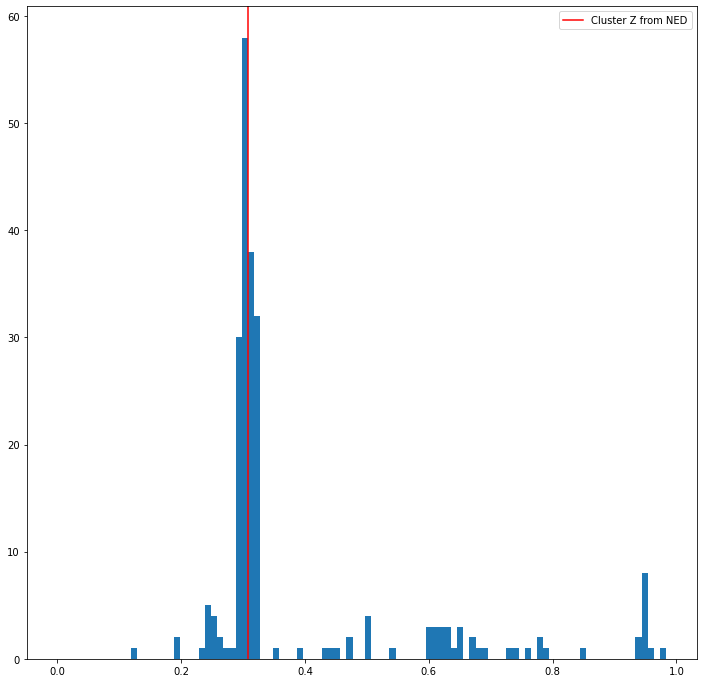

In [90]:
num_bins = 100
max_value = z_best[~np.isnan(z_best)].max()
bin_width = (max_value / num_bins)
print('single bin width=', bin_width)
plt.hist(z_best, bins=[i * bin_width for i in range(num_bins)]);
plt.axvline(0.308, c='r', label='Cluster Z from NED')
plt.legend()
plt.show()

# Load Input Filters

In [91]:
def print_filter_file(path):
    with open(path) as f:
        for line in f:
            print(line.replace("\n", ""))

In [92]:
input_filter_file = os.path.abspath('hst_filters_muse.dat')

In [93]:
print_filter_file(input_filter_file)

KCORRECT_DIR
data/filters/clash_acs_f435w.par
data/filters/clash_acs_f606w.par
data/filters/clash_acs_f814w.par
data/filters/clash_wfc3_f105w.par
data/filters/clash_wfc3_f140w.par
data/filters/clash_wfc3_f160w.par


In [94]:
kcorrect.load_templates()
kcorrect.load_filters(input_filter_file)

# Fit Nonnegative Sums

In [95]:
kcorrect_constants = []

for i in range(0, num_sources):
    
    all_maggies = np.array([maggies[f][i] for f in filter_list], dtype=float)
    all_maggies_err = np.array([maggies_err[f][i] for f in filter_list], dtype=float)
    
    z = z_best[i]
    
    constants = kcorrect.fit_nonneg(z, all_maggies, all_maggies_err)
    
    kcorrect_constants.append(constants)
    

# Reconstruct Maggies

In [96]:
def multi_reconstruct_maggies(kcorrect_constants, filter_list, redshift=-1.0):
    re_maggies = {f: [] for f in filter_list}
    
    for constants in kcorrect_constants:
        _, *result = kcorrect.reconstruct_maggies(constants, redshift=redshift)

        for i, f in enumerate(filter_list):
            re_maggies[f].append(result[i])
            
    for i, f in enumerate(filter_list):
        re_maggies[f] = np.array(re_maggies[f])
        
    return re_maggies
    

In [97]:
def stack_filter_dict(dictionary):
    return np.stack(tuple(dictionary.values()), axis=-1)

In [98]:
re_maggies = multi_reconstruct_maggies(kcorrect_constants, filter_list)
re_maggies_z0 = multi_reconstruct_maggies(kcorrect_constants, filter_list, redshift=0)

# Compare Reconstructed Maggies Vs Input Maggies

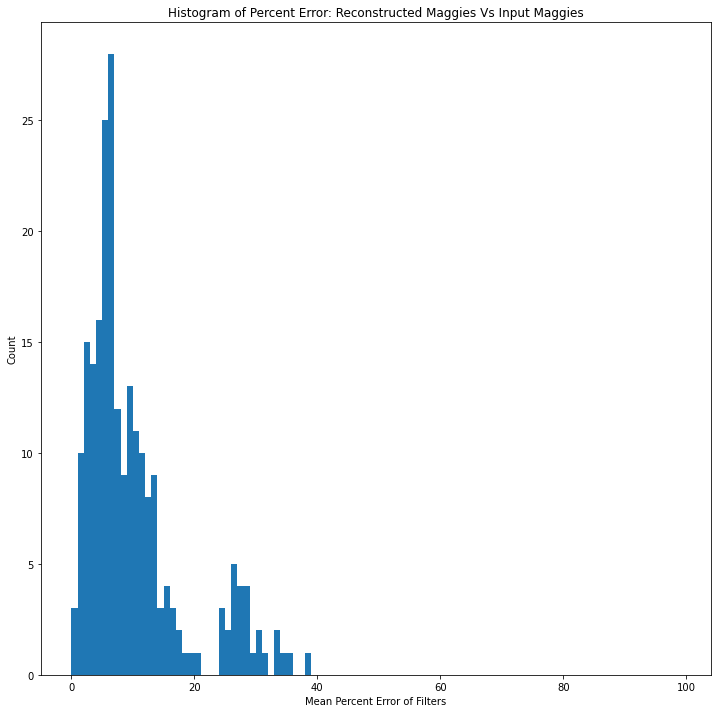

N=228


In [99]:
all_re_maggies = stack_filter_dict(re_maggies)
all_maggies = stack_filter_dict(maggies)

percent_err = 100 * abs(all_re_maggies - all_maggies) / all_maggies
percent_err = (percent_err).mean(axis=1)

bins = list(range(100))
plt.hist(percent_err, bins=bins)

#plt.xticks(bins, ["{:0.2e}".format(i) for i in bins], rotation='vertical')

plt.title("Histogram of Percent Error: Reconstructed Maggies Vs Input Maggies")
plt.xlabel("Mean Percent Error of Filters")
plt.ylabel("Count")
plt.show()

"""
bins = 0.1*np.array(range(100))
plt.hist(percent_err, bins=bins)

plt.title("Histogram of Percent Error: Reconstructed Maggies Vs Input Maggies")
plt.xlabel("Mean Percent Error of Filters")
plt.ylabel("Count")
plt.show()
"""
print("N={}".format(len(percent_err)))

# Load Johnson Filters

In [100]:
johnson_filter_list = ['u', 'b', 'v']

johnson_correction_const_dict = {
    'u': -0.79,
    'b': + 0.09,
    'v': -0.02
}

johnson_correction_const = np.array([johnson_correction_const_dict[key] for key in johnson_filter_list])

In [101]:
johnson_filter_file = os.path.abspath('johnson_ubv.dat')

In [102]:
print_filter_file(johnson_filter_file)

KCORRECT_DIR
data/filters/bessell_U.par
data/filters/bessell_B.par
data/filters/bessell_V.par


In [103]:
kcorrect.load_templates()
kcorrect.load_filters(johnson_filter_file)

# Compute Johnson Maggies 

In [104]:
johnson_maggies_z0 = multi_reconstruct_maggies(kcorrect_constants, johnson_filter_list, redshift=0)

# Compute Vega Mag 

In [105]:
m_vega_mags = {}
M_vega_mags = {}

# Johnson filters
for i, f in enumerate(johnson_filter_list):
    m_vega_mags[f] = -2.5 * np.log10(johnson_maggies_z0[f]) + johnson_correction_const_dict[f]
    M_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(z_best).value
"""
# Original filters
for i, f in enumerate(filter_list):
    m_vega_mags[f] = -2.5 * np.log10(re_maggies_z0[f]) + hst_correction_const_dict[f]
    M_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(z_best).value
"""



'\n# Original filters\nfor i, f in enumerate(filter_list):\n    m_vega_mags[f] = -2.5 * np.log10(re_maggies_z0[f]) + hst_correction_const_dict[f]\n    M_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(z_best).value\n'

# Compute Surface Brightnesses

In [106]:
m_b = m_vega_mags['b']

In [107]:
r_half_light_arcsec = radii

In [108]:
surface_brightness = m_b + 5 * np.log10(r_half_light_arcsec) + 2.5 * np.log10(2 * np.pi) - 10 * np.log10(1+z_best)
surface_brightness[np.where(np.isnan(surface_brightness))] = np.nan

# Make Catalog

In [109]:
raw_astro_deep_cat

# ID,RA,DEC,Z,CONFID,TYPE,MUL,F435W,F435W_ERR,F606W,F606W_ERR,F814W,F814W_ERR,F105W,F105W_ERR,F110W,F110W_ERR,F140W,F140W_ERR,F160W,F160W_ERR,MU,MU_ERR
str5,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
M39,3.5889097,-30.3821391,6.6439,2,6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,3.342,0.116
2115,3.5938048,-30.4154482,6.5876,2,6,--,-29.4385,99.0,-29.2385,99.0,29.4057,0.2892,-2.0,99.0,26.5916,0.0397,26.7413,0.0434,26.7002,0.0383,4.08,0.076
M38,3.5801476,-30.4079034,6.5565,2,6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,3.507,0.104
M37,3.5830603,-30.4118859,6.5195,2,6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,3.367,0.116
10609,3.598419,-30.3872993,6.3755,2,6,--,-30.3958,99.0,30.129,0.3502,29.6988,0.1612,29.8414,0.2013,29.6225,0.2425,-30.1464,99.0,30.0003,0.3039,2.279,0.069
5353,3.6010732,-30.4039891,6.3271,3,6,--,-29.5695,99.0,-29.4675,99.0,29.0818,0.1802,27.8385,0.0604,27.8021,0.0857,27.9608,0.0946,28.0404,0.0938,3.812,0.122
2785,3.5676318,-30.4118712,6.2737,2,6,--,-29.9169,99.0,29.5461,0.3228,28.8554,0.1205,28.6472,0.1217,28.7018,0.1896,28.7897,0.1977,28.5387,0.1413,1.68,0.028
M36,3.578052,-30.4131601,6.0938,2,6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,2.134,0.043
M35,3.5685679,-30.3990763,5.9971,2,6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,2.384,0.064


In [123]:
# Define Column Names 
col_names = [
    'id',
    'ra', 'dec',
    'zbest',
    'surface_brightness',
    'r_half_light_arcsec',
    
] 

col_names += ["m_{}".format(f.replace('MAG_','')) for f in m_vega_mags.keys()] 
col_names += ["M_{}".format(f.replace('MAG_','')) for f in M_vega_mags.keys()]
col_names += ["kcorrect_constant_{}".format(i) for i in range(len(kcorrect_constants[0]))]

# Construct the rows of the catalog
final_catalog_rows = [
    astro_deep_cat['# ID'],
    astro_deep_cat['RA'],
    astro_deep_cat['DEC'],
    z_best,
] 
final_catalog_rows += [surface_brightness]
final_catalog_rows += [r_half_light_arcsec]
final_catalog_rows += list(m_vega_mags.values()) 
final_catalog_rows += list(M_vega_mags.values()) 
final_catalog_rows += list(map(list, zip(*kcorrect_constants)))    

# Make the catalog
final_catalog = Table(data=final_catalog_rows, names=col_names)


# Mask out sources with missing values
# r80 is a good indicator that things failed so we use that column to mask
catalog_mask =  (
    #np.invert(final_catalog['surface_brightness'].mask) & 
    np.invert(np.isnan(np.array(surface_brightness, dtype=float))).astype(bool) & 
    np.invert(np.isnan(radii)).astype(bool) #&
    #(final_catalog['m_u'] < 23).astype(bool) # &
    #(final_catalog['surface_brightness'] < 25)
    #(final_catalog['zbest'] > 0.25).astype(bool)&
    #(final_catalog['zbest'] < 0.35).astype(bool)
)

print(len(final_catalog))
final_catalog = final_catalog[catalog_mask]
print(len(final_catalog))

final_catalog.sort(keys="r_half_light_arcsec", reverse=1)

228
164


In [121]:
final_catalog

id,ra,dec,zbest,surface_brightness,r_half_light_arcsec,m_u,m_b,m_v,M_u,M_b,M_v,kcorrect_constant_0,kcorrect_constant_1,kcorrect_constant_2,kcorrect_constant_3,kcorrect_constant_4,kcorrect_constant_5
str5,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32
6034,3.5920311,-30.4057301,0.3187,24.279880566979028,2.9260658992937474,21.502674,21.15447,20.340223,-19.6099677333266,-19.958171392384216,-20.772418523731872,0.3187,3.3987442e-07,3.1e-44,6.2326855e-08,1.8085641e-06,7.368289e-12
7824,3.5862486,-30.4001634,0.2998,23.488130996432975,2.292483034156054,21.116346,20.829916,20.100012,-19.842145257948573,-20.128575616835292,-20.85847979163998,0.2998,6.7737284e-07,3.2e-44,1.4977485e-07,1.4771881e-06,3.5156095e-12
7954,3.5865719,-30.3993588,0.323,24.18075855778087,1.957760011064442,22.26687,21.94211,21.158405,-18.879671105175298,-19.204431542187017,-19.988136299877446,0.323,3.8071846e-08,8.3e-44,3.136618e-08,9.309571e-07,4.0227291e-13
10508,3.600023,-30.3897178,0.19,24.29780091555184,1.661888767438821,22.232193,21.954811,21.238354,-17.600757595659708,-17.878139492632364,-18.594596859575724,0.19,3.2017218e-07,9.0319595e-34,6.000837e-08,3.9205625e-07,1.3280856e-14
10689,3.5947965,-30.3916457,0.3008,22.69746871785075,1.4198122953814947,21.422771,21.08297,20.279438,-19.54409622716919,-19.88389801549927,-20.687429662227785,0.3008,1.540922e-07,9.1e-44,6.2141346e-08,2.1048309e-06,6.706729e-12
9072,3.5989643,-30.3975202,0.3164,24.105187119291717,1.4168236969610337,22.866829,22.547037,21.770023,-18.227508201423547,-18.54729999524679,-19.324313773933312,0.3164,1.6947284e-08,8.3e-44,1.8635703e-08,5.2746384e-07,2.6295914e-13
9778,3.5874299,-30.393272,0.6011,23.244961790278747,1.3002683585630619,22.842886,22.723532,22.007633,-19.915135840039625,-20.0344900880865,-20.750388601880445,0.6011,1.7345859e-07,7.3214265e-12,1.3454529e-08,2.1042432e-07,7.036783e-09
7257,3.5903377,-30.4003737,0.4971,22.57132686105992,1.1627928312218643,22.243418,22.000874,21.23019,-20.013753605659076,-20.256297779853412,-21.02698106842763,0.4971,4.4254253e-07,3.2911267e-11,4.5580823e-08,4.0160538e-07,7.999182e-12
6892,3.5879386,-30.4008481,0.3153,23.360999400741665,1.1358954454377166,22.536005,22.279106,21.593498,-18.549534566321334,-18.806433446326217,-19.492041356482467,0.3153,2.7064392e-10,6.2e-44,3.7940257e-08,5.071476e-07,1.9861542e-14


In [122]:
final_catalog

id,ra,dec,zbest,surface_brightness,r_half_light_arcsec,m_u,m_b,m_v,M_u,M_b,M_v,kcorrect_constant_0,kcorrect_constant_1,kcorrect_constant_2,kcorrect_constant_3,kcorrect_constant_4,kcorrect_constant_5
str5,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32
6034,3.5920311,-30.4057301,0.3187,24.279880566979028,2.9260658992937474,21.502674,21.15447,20.340223,-19.6099677333266,-19.958171392384216,-20.772418523731872,0.3187,3.3987442e-07,3.1e-44,6.2326855e-08,1.8085641e-06,7.368289e-12
7824,3.5862486,-30.4001634,0.2998,23.488130996432975,2.292483034156054,21.116346,20.829916,20.100012,-19.842145257948573,-20.128575616835292,-20.85847979163998,0.2998,6.7737284e-07,3.2e-44,1.4977485e-07,1.4771881e-06,3.5156095e-12
7954,3.5865719,-30.3993588,0.323,24.18075855778087,1.957760011064442,22.26687,21.94211,21.158405,-18.879671105175298,-19.204431542187017,-19.988136299877446,0.323,3.8071846e-08,8.3e-44,3.136618e-08,9.309571e-07,4.0227291e-13
10508,3.600023,-30.3897178,0.19,24.29780091555184,1.661888767438821,22.232193,21.954811,21.238354,-17.600757595659708,-17.878139492632364,-18.594596859575724,0.19,3.2017218e-07,9.0319595e-34,6.000837e-08,3.9205625e-07,1.3280856e-14
10689,3.5947965,-30.3916457,0.3008,22.69746871785075,1.4198122953814947,21.422771,21.08297,20.279438,-19.54409622716919,-19.88389801549927,-20.687429662227785,0.3008,1.540922e-07,9.1e-44,6.2141346e-08,2.1048309e-06,6.706729e-12
9072,3.5989643,-30.3975202,0.3164,24.105187119291717,1.4168236969610337,22.866829,22.547037,21.770023,-18.227508201423547,-18.54729999524679,-19.324313773933312,0.3164,1.6947284e-08,8.3e-44,1.8635703e-08,5.2746384e-07,2.6295914e-13
9778,3.5874299,-30.393272,0.6011,23.244961790278747,1.3002683585630619,22.842886,22.723532,22.007633,-19.915135840039625,-20.0344900880865,-20.750388601880445,0.6011,1.7345859e-07,7.3214265e-12,1.3454529e-08,2.1042432e-07,7.036783e-09
7257,3.5903377,-30.4003737,0.4971,22.57132686105992,1.1627928312218643,22.243418,22.000874,21.23019,-20.013753605659076,-20.256297779853412,-21.02698106842763,0.4971,4.4254253e-07,3.2911267e-11,4.5580823e-08,4.0160538e-07,7.999182e-12
6892,3.5879386,-30.4008481,0.3153,23.360999400741665,1.1358954454377166,22.536005,22.279106,21.593498,-18.549534566321334,-18.806433446326217,-19.492041356482467,0.3153,2.7064392e-10,6.2e-44,3.7940257e-08,5.071476e-07,1.9861542e-14


# Cluster Catalog

In [113]:
cluster_mask = np.array([np.where(final_catalog['id'] == ID )[0][0] for ID in range(100001, 100016) if len(np.where(final_catalog['id'] == ID )[0])])

cluster_catalog = final_catalog[cluster_mask]

cluster_M_B = np.array(cluster_catalog['M_b'])
cluster_M_V = np.array(cluster_catalog['M_v'])
cluster_B_minus_V = cluster_M_B - cluster_M_V
cluster_sb = cluster_catalog['surface_brightness']

/opt/conda/envs/lcbg/lib/python3.8/site-packages/astropy/table/column.py:1020: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


# LCBG Catalog

In [114]:
M_B = np.array(final_catalog['M_b'])
M_V = np.array(final_catalog['M_v'])
B_minus_V = M_B-M_V
sb = final_catalog['surface_brightness']

r_half_light_arcsec_list = final_catalog['r_half_light_arcsec']
lcbg_mask = np.where(
    (B_minus_V < 0.5).astype(int) & 
    (sb < 21).astype(int) & 
    (M_B < -18.5).astype(int) & 
    
    #(final_catalog['zbest'] < 0.5).astype(int)&
    #(final_catalog['zbest'] > 0.1).astype(int)&
    
    #(r_half_light_arcsec_list < 0.5).astype(int) & # Guzman et al. (1997) and Phillips et al. (1997)
    (0.2 < r_half_light_arcsec_list).astype(int)   # Remove star like objects
)

lcbg_catalog = final_catalog[lcbg_mask]
len(lcbg_catalog)

1

# Save Catalog

In [115]:
output_catalog_filename = "astrodeep_abell370_catalog.csv"
output_lcbg_catalog_filename = "astrodeep_abell370_lcbg_catalog.csv"

In [116]:
#final_catalog.write(output_catalog_filename, format="ascii.csv", overwrite=True)
#lcbg_catalog.write(output_lcbg_catalog_filename, format="ascii.csv", overwrite=True)

# Plots

### Plot B-V vs M<sub>b</sub> 

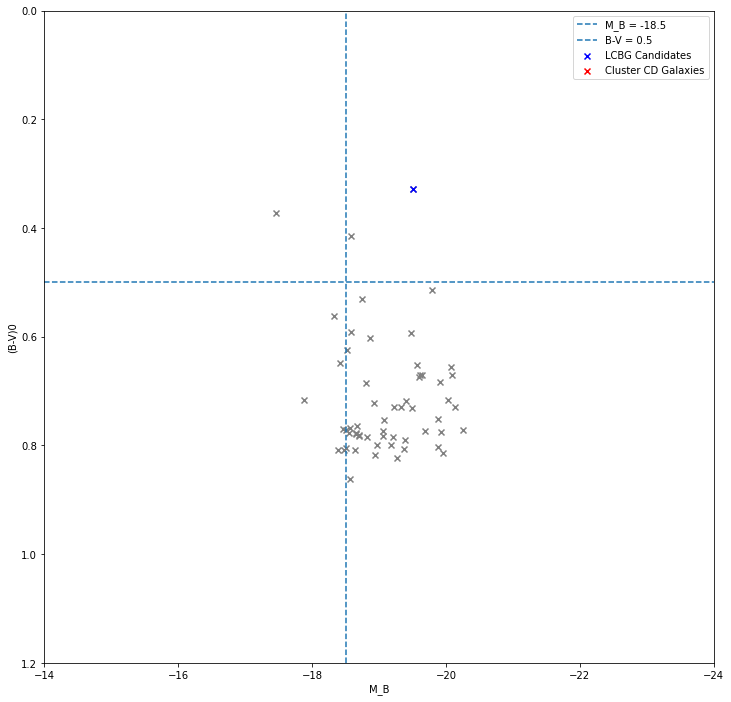

In [117]:
plt.scatter(M_B, B_minus_V, color="gray", marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(0.5, label='B-V = 0.5', linestyle='--')

plt.scatter(M_B[lcbg_mask], B_minus_V[lcbg_mask], label='LCBG Candidates', c='b', marker='x')
plt.scatter(cluster_M_B, cluster_B_minus_V, label='Cluster CD Galaxies', c='r', marker='x')

plt.xlabel('M_B')
plt.ylabel('(B-V)0')

plt.xlim(-14, -24)
plt.ylim(1.2, -0)

plt.legend()


### Plot Surface Brightness Vs M_B

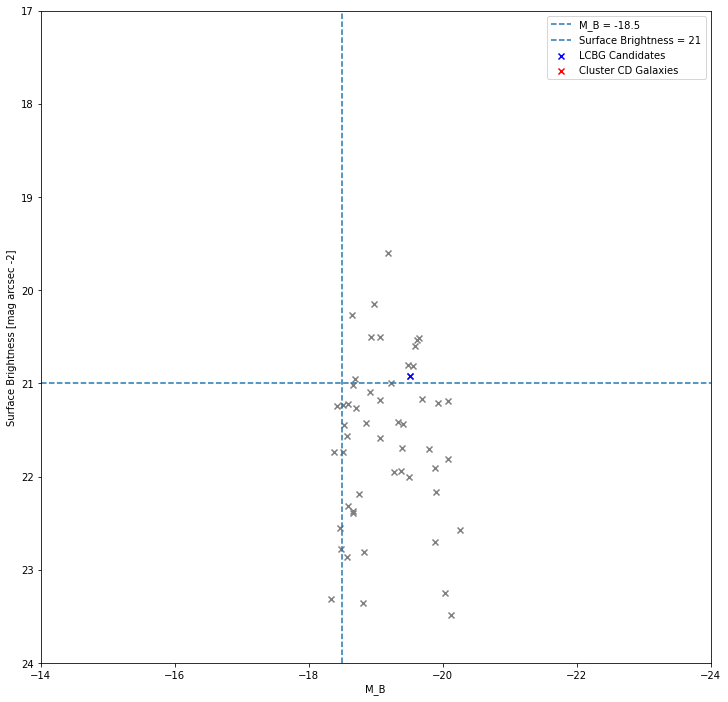

In [118]:
plt.scatter(M_B, sb, color="gray", marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(M_B[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')
plt.scatter(cluster_M_B, cluster_sb, label='Cluster CD Galaxies', c='r', marker='x')

plt.xlabel('M_B')
plt.ylabel('Surface Brightness [mag arcsec -2]')

plt.xlim(-14, -24)
plt.ylim(24, 17)

plt.legend()

### Plot Surface Brightness Vs B-V

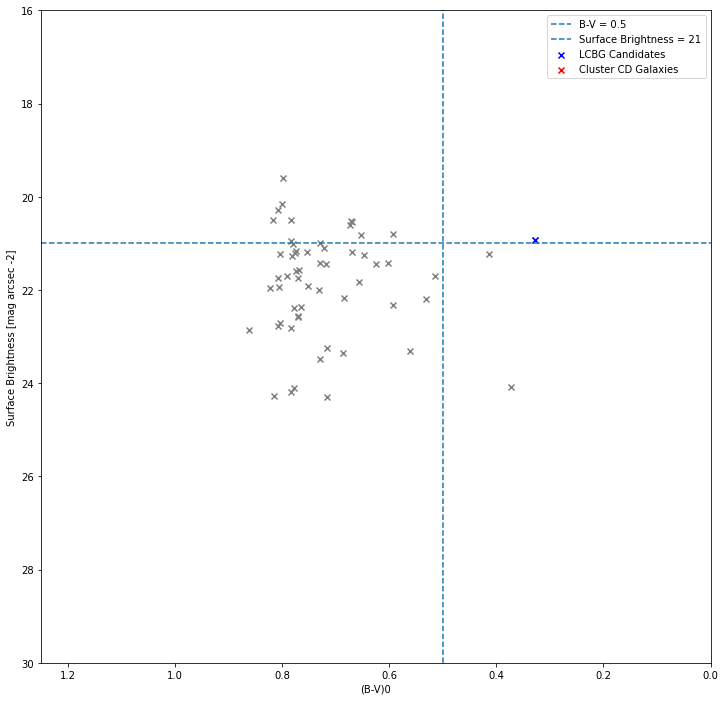

In [119]:
plt.scatter(B_minus_V, sb, color="gray", marker='x')

plt.axvline(0.5, label='B-V = 0.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(B_minus_V[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')
plt.scatter(cluster_B_minus_V, cluster_sb, label='Cluster CD Galaxies', c='r', marker='x')

plt.xlabel('(B-V)0')
plt.ylabel('Surface Brightness [mag arcsec -2]')

plt.xlim(1.25, 0.)
plt.ylim(30, 16)

plt.legend()

# Save plots

In [62]:
Table([M_B, B_minus_V, sb], names=['M_B', 'B_minus_V', 'sb']).write('robel_B_minus_V_vs_sb.dat', format='ascii', overwrite=True)

## Plot (MAG_I814 - MAG_Y105) Vs. MAG_I814

Text(0, 0.5, 'm_I814')

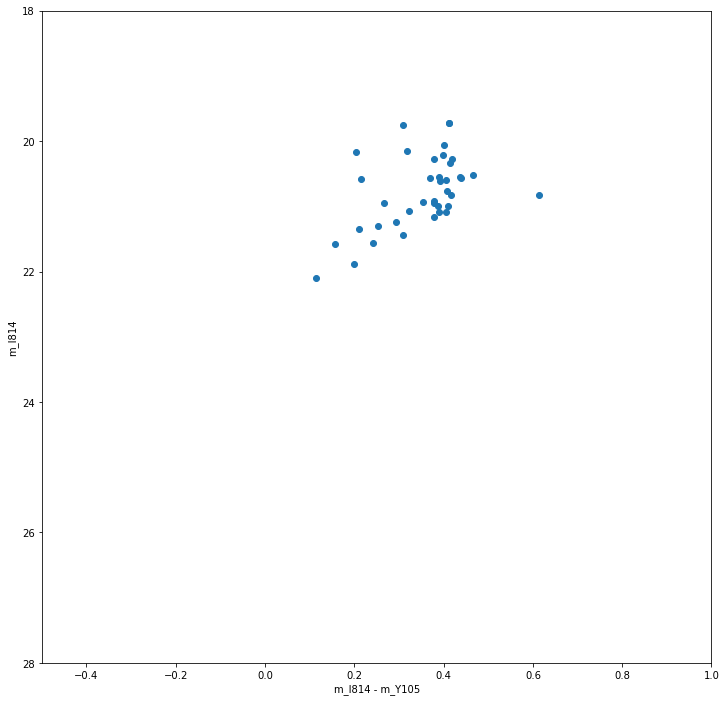

In [81]:
plt.scatter(mags['F814W'][catalog_mask]-mags['F105W'][catalog_mask], 
            mags['F814W'][catalog_mask])
plt.ylim(28, 18)
plt.xlim(-0.5, 1);
plt.xlabel("m_I814 - m_Y105")
plt.ylabel("m_I814")

`https://arxiv.org/pdf/1706.02521.pdf`

# Other

In [39]:
plt.scatter(j['MAG_I814']-mags['MAG_Y105'], mags[ 'MAG_I814'])
plt.ylim(28, 18)
plt.xlim(-0.5, 1);
plt.xlabel("m_I814 - m_Y105")
plt.ylabel("m_I814")

NameError: name 'j' is not defined

In [ ]:
plt.scatter(M_B, sb, color="gray", marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(M_B[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')
plt.scatter(cluster_M_B, cluster_sb, label='Cluster CD Galaxies', c='r', marker='x')

plt.xlabel('M_B')
plt.ylabel('Surface Brightness [mag arcsec -2]')

plt.xlim(-14, -24)
#plt.ylim(30, 16)

plt.legend()

In [ ]:
plt.scatter(M_B, sb, color="gray", marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(M_B[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')
#plt.scatter(cluster_M_B, cluster_sb, label='Cluster CD Galaxies', c='r', marker='x')

plt.xlabel('M_B')
plt.ylabel('Surface Brightness [mag arcsec -2]')

plt.xlim(-14, -30)
plt.ylim(11, 30)
##plt.ylim(30, 16)

plt.legend()

In [ ]:
[np.array(r_half_light_arcsec)[np.where(~np.isnan(r_half_light_arcsec))].min(),
np.array(r_half_light_arcsec)[np.where(~np.isnan(r_half_light_arcsec))].max(),
np.array(r_half_light_arcsec)[np.where(~np.isnan(r_half_light_arcsec))].mean()]

In [ ]:
"""
input_catalog_formatter = "hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz_catalog_petrosian.csv"
robel_cat = Table.read(input_catalog_formatter.format('f105w'))

robel_ra, robel_dec = np.array([ coord.split(',') for coord in robel_cat['sky_centroid']]).astype(float).transpose()

radii = []
for row in astro_deep_cat:
    ra, dec = row['RA'], row['DEC'] 
    
    coord_delta = ((robel_ra - ra)**2 + (robel_dec - dec)**2)
    if coord_delta.min() > 1e-06:
        radii.append(np.nan)
        continue
        print(coord_delta.min())
    idx = coord_delta.argmin()
    
    radii.append(robel_cat[idx]['r_half_light_arcsec'])

radii = np.array(radii)
""";

In [ ]:
"""
robel_cat = Table.read('hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz_catalog_fine_petrosian.csv')
robel_ra, robel_dec = np.array([ coord.split(',') for coord in robel_cat['sky_centroid']]).astype(float).transpose()

radii = np.zeros_like(z_best)
radii[:] = np.nan

for col, [ra, dec] in enumerate(zip(robel_ra, robel_dec)):
    
    coord_delta = ((astro_deep_cat['RA'] - ra)**2 + (astro_deep_cat['DEC'] - dec)**2)
    if coord_delta.min() > 1e-05:
        print(coord_delta.min())
        continue
    idx = coord_delta.argmin()
    
    if not isinstance(robel_cat[col]['r_half_light_arcsec'], float):
        #radii[idx] = robel_cat[col]['semimajor_axis_sigma']
        radii[idx] = np.nan
    else:
        radii[idx] = robel_cat[col]['r_half_light_arcsec']
        
    if astro_deep_cat['ID'][idx]  == 100013:
        print(radii[idx], robel_cat[col]['id'])

radii = np.array(radii)
#radii[np.where(np.isnan(radii))] = 0.308
print("Num sources with radii matchs: ", np.where(sep2d.arcsec > 0.1)[0].shape[0])

print("Fraction sources with radii matchs: ", 1 - np.where(sep2d.arcsec > 0.1)[0].shape[0] / len(astro_deep_cat))
""";